Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo01
Load previous particle trace fit checking results from "particle_fits_checked.pkl"


<Figure size 640x480 with 0 Axes>

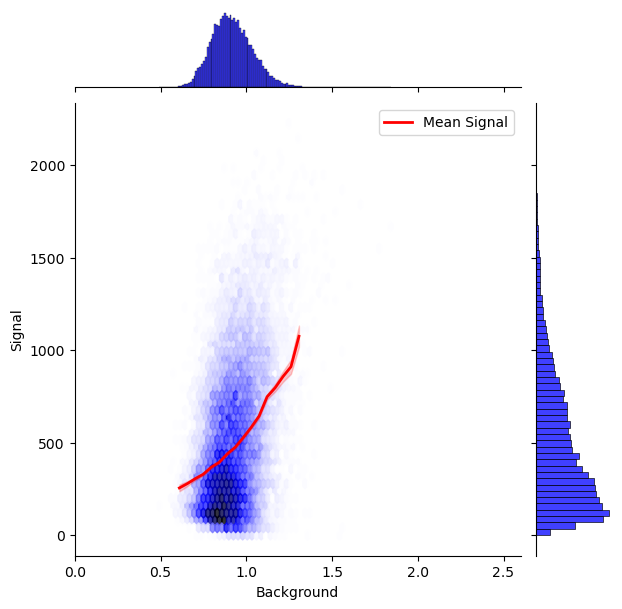

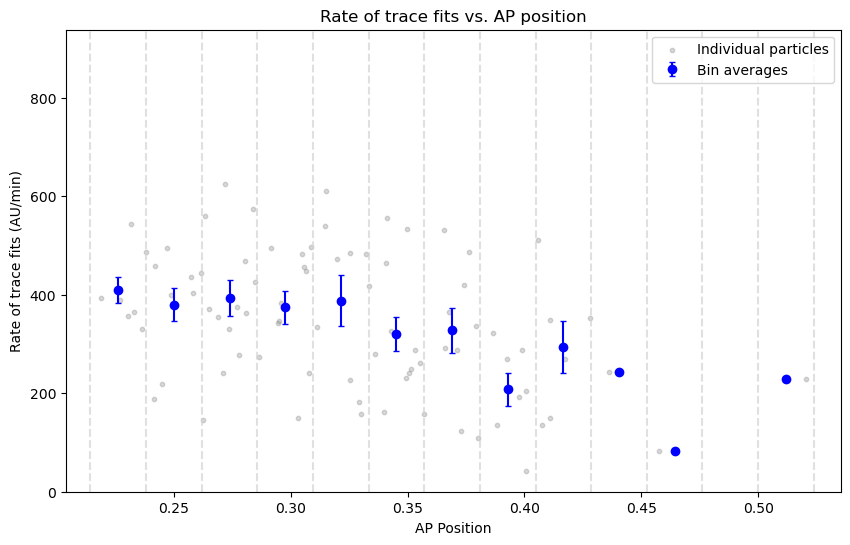

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo02
Load previous particle trace fit checking results from "particle_fits_checked.pkl"


<Figure size 640x480 with 0 Axes>

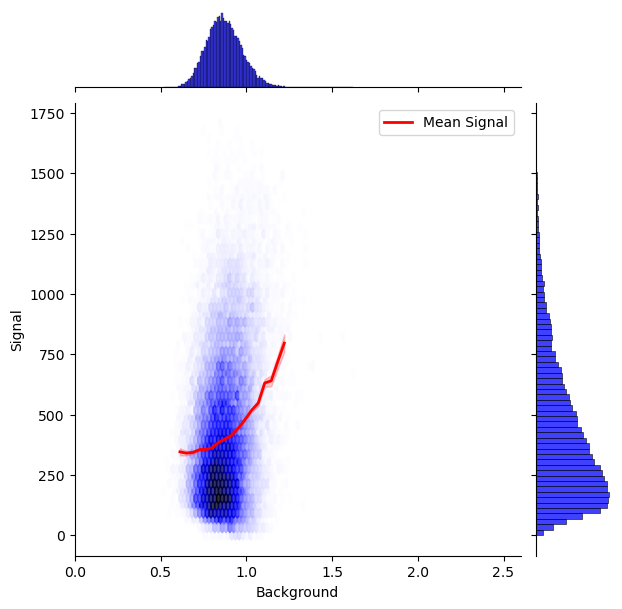

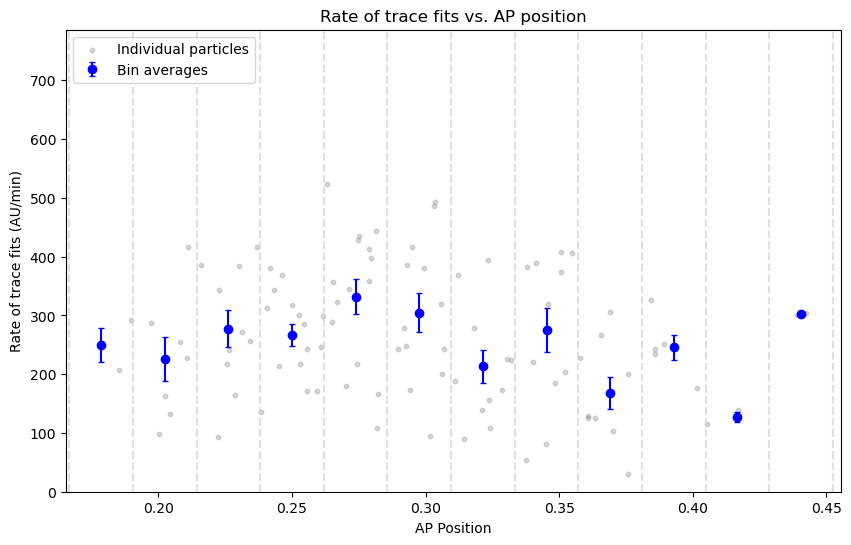

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Var2(001)_embryo20
Load previous particle trace fit checking results from "particle_fits_checked.pkl"


<Figure size 640x480 with 0 Axes>

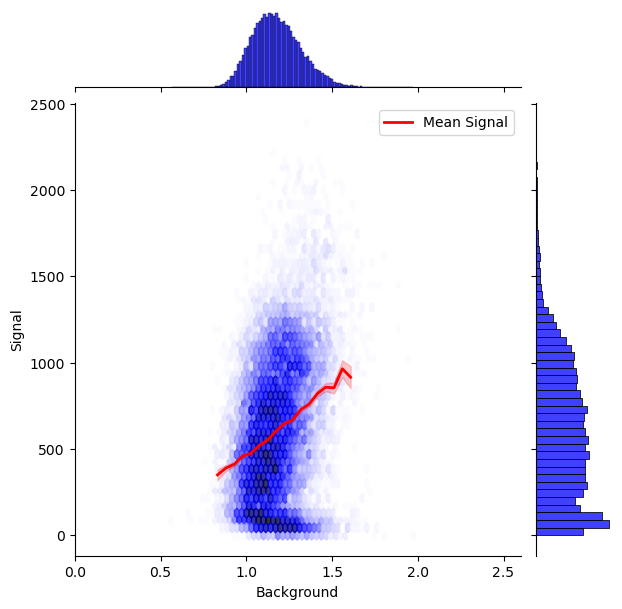

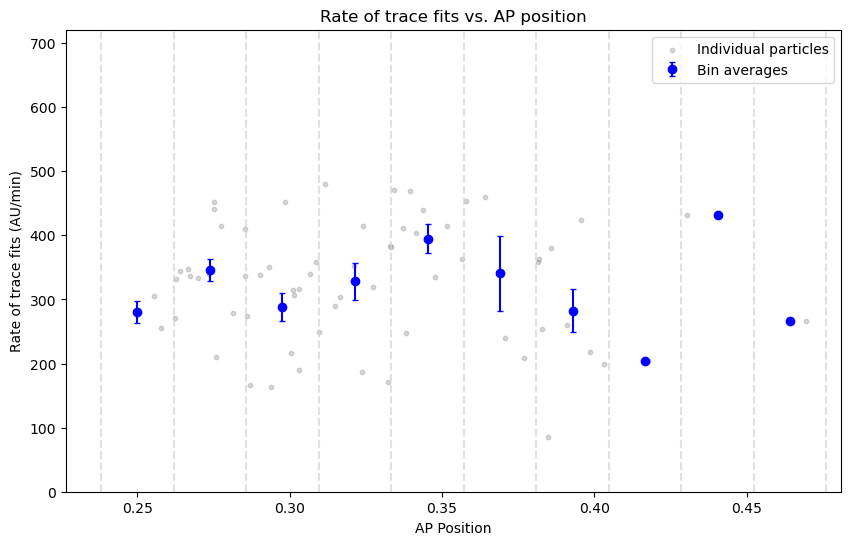

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Var2(001)_embryo38
Load previous particle trace fit checking results from "particle_fits_checked.pkl"


<Figure size 640x480 with 0 Axes>

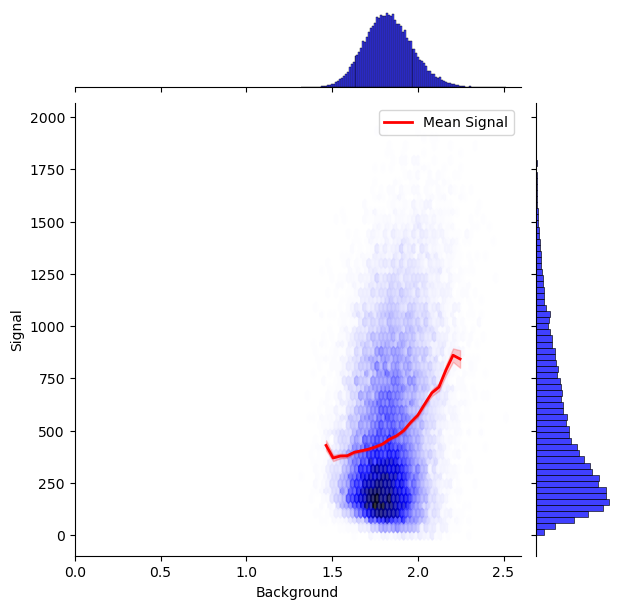

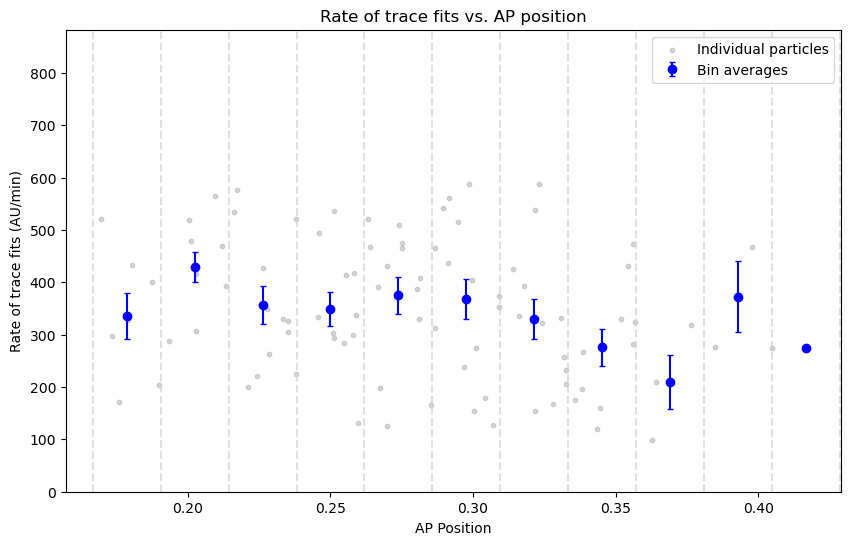

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-14/MCP-mSG_His-RFP_Var2(001)_embryo28
Load previous particle trace fit checking results from "particle_fits_checked.pkl"


<Figure size 640x480 with 0 Axes>

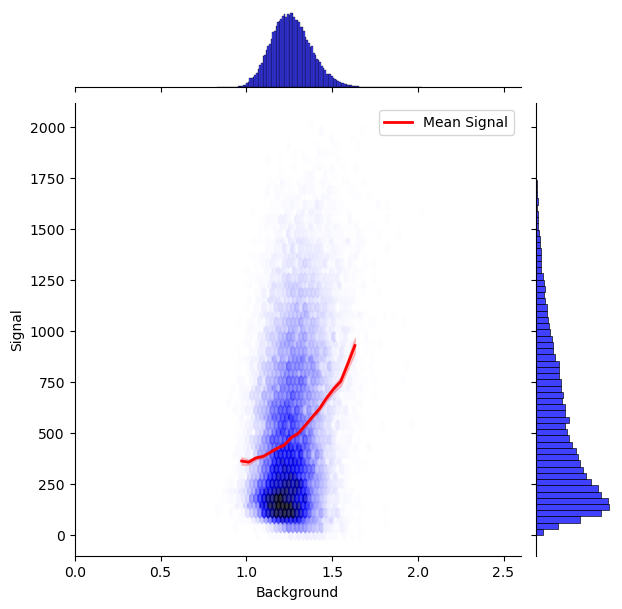

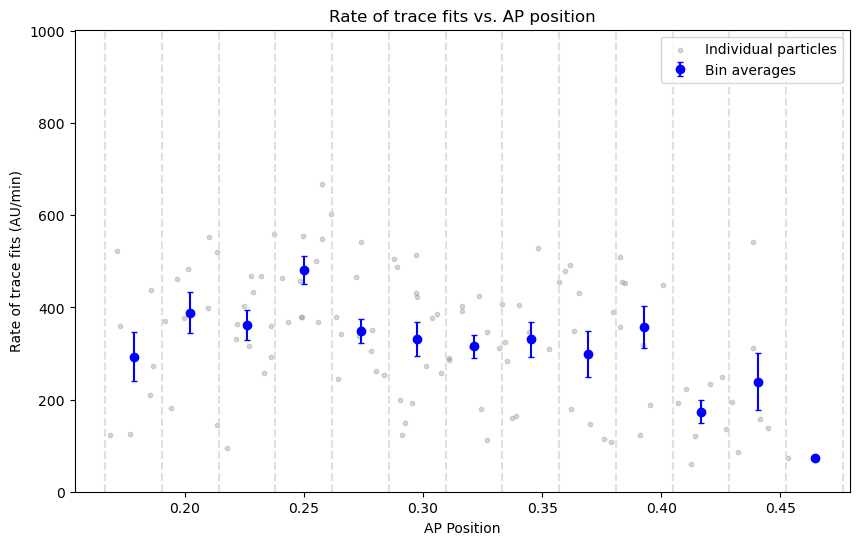

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-15/MCP-mSG_His-RFP_Var2(001)_embryo01
Load previous particle trace fit checking results from "particle_fits_checked.pkl"


<Figure size 640x480 with 0 Axes>

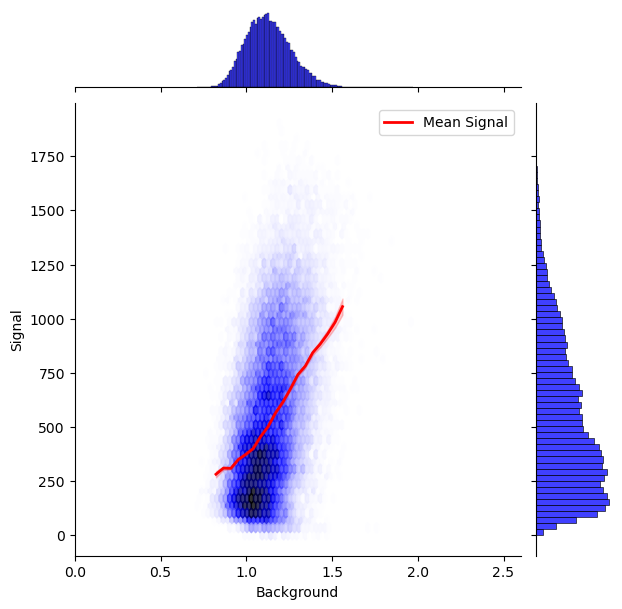

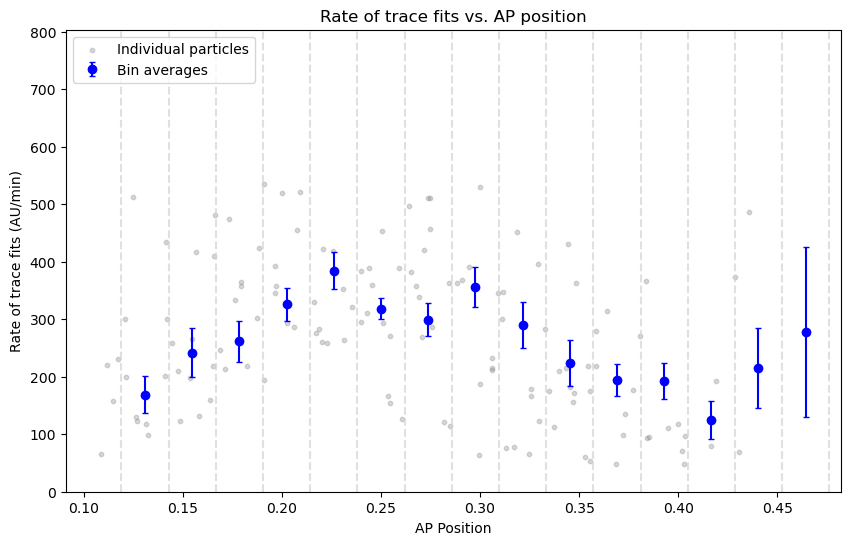

In [4]:
from transcription_pipeline.RateExtraction import FitAndAverage
from transcription_pipeline import spot_pipeline
from transcription_pipeline import nuclear_pipeline
# from sklearn.metrics import r2_score  # Still useful
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns

# Specify here at what frame NC14 starts
nc14_start_frame = 0

# Any trace with frame number smaller than min_frames will be filtered out
min_frames = 40

# Number of bins you want to split the full embryo into
num_bins = 42

# List to hold result rows
results = []
for i, embryo_id in enumerate(embryo_list):  # This ensures we only iterate over existing items
    # Define the dataset path
    test_dataset_name = dataset_folder + embryo_list[i]
    print('Dataset Path: ' + test_dataset_name)

    ### Signal vs. Background Analysis
    spot_tracking = spot_pipeline.Spot()
    spot_tracking.read_results(name_folder=test_dataset_name)

    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)

    spot_df = spot_tracking.spot_dataframe
    detected_spots = spot_df[spot_df["particle"] != 0]

    signal = np.array(detected_spots['intensity_from_neighborhood'])
    background = np.array(detected_spots['background_intensity_from_neighborhood'])

    nuclear_df = nuclear_tracking.mitosis_dataframe
    nuclear_df = nuclear_df.sort_values(by='frame')
    avg_nuclear_intensity = nuclear_df['nuclear_intensity_mean'].to_numpy()

    # Plot signal vs background
    plt.figure()
    g = sns.jointplot(x=background, y=signal, kind='hex', color='blue', alpha=0.8)
    plt.xlim(left=0, right=2.6)

    # Bin the background and compute mean signal and standard error
    bins = np.linspace(np.min(background), np.max(background), 30)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    digitized = np.digitize(background, bins)

    # Set minimum number of points required per bin
    min_points = 50
    mean_signal = []
    std_signal = []
    valid_centers = []

    for i in range(1, len(bins)):
        bin_points = signal[digitized == i]
        if len(bin_points) >= min_points:
            mean_signal.append(np.mean(bin_points))
            std_signal.append(np.std(bin_points) / np.sqrt(len(bin_points)))
            valid_centers.append(bin_centers[i - 1])

    # Add line showing mean signal vs background with shaded error region
    g.ax_joint.plot(valid_centers, mean_signal, 'r-', linewidth=2, label='Mean Signal')
    g.ax_joint.fill_between(valid_centers,
                            np.array(mean_signal) - np.array(std_signal),
                            np.array(mean_signal) + np.array(std_signal),
                            color='red', alpha=0.2)
    g.ax_joint.legend()

    plt.xlabel('Background')
    plt.ylabel('Signal')

    ### Slope Analysis
    dataframe_path = test_dataset_name + '/compiled_dataframe.pkl'
    compiled_dataframe = pd.read_pickle(dataframe_path)

    fit_and_average = FitAndAverage(compiled_dataframe, nc14_start_frame, min_frames, num_bins, test_dataset_name)
    x, y, y_err, _, _ = fit_and_average.average_particle_fits()

    results.append({
        'embryo_id': embryo_id,  # Use the embryo_id directly from the loop
        'avg_bkg': np.mean(background),
        'avg_signal': np.mean(signal),
        'avg_nuclear_intensity': avg_nuclear_intensity,
        'x': x,
        'y': y,
        'y_err': y_err
    })

# Convert results to DataFrame
average_fit_df = pd.DataFrame(results)


In [ ]:
average_fit_df

/tmp/ipykernel_611355/2019548552.py:31: RuntimeWarning: Mean of empty slice
  avg_rates = [np.nanmean(bin_dict[bin]) for bin in avg_bins]
/home/nickgravina/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


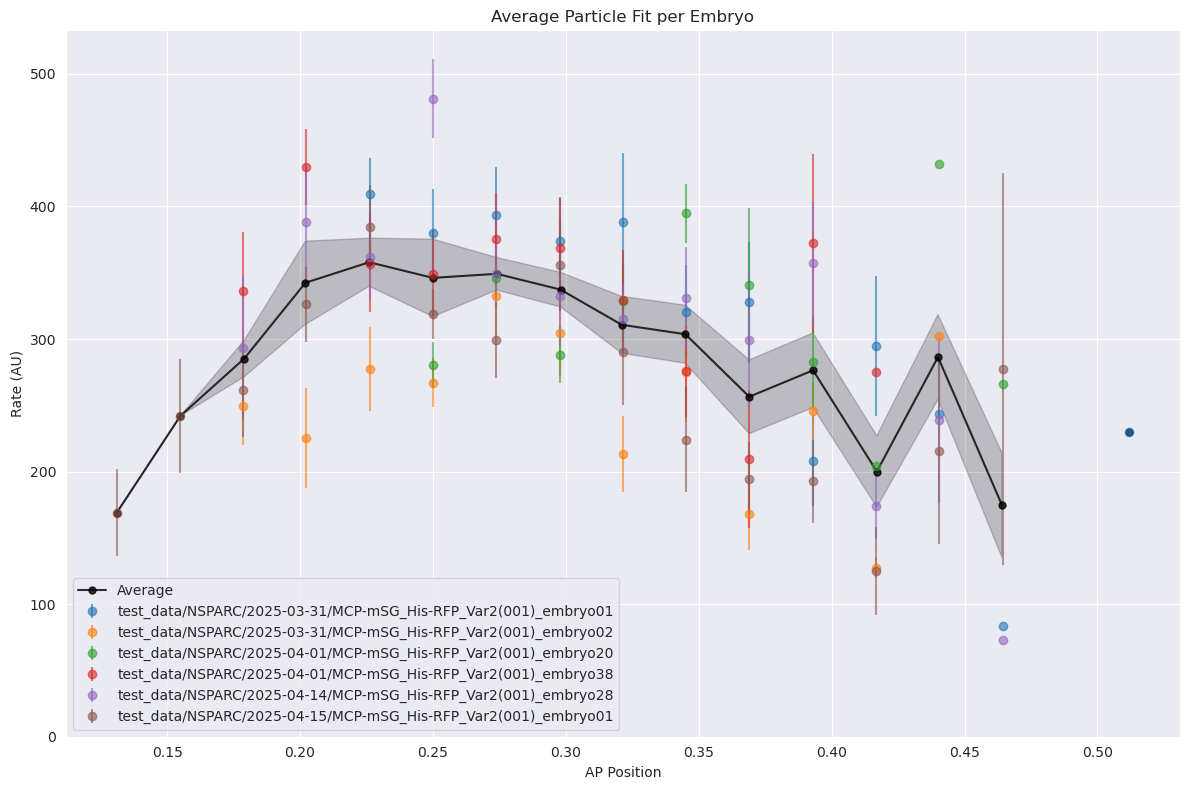

In [5]:

import pandas as pd

plt.figure(figsize=(12, 8))

# Store all embryo curves
all_x = []
all_y = []

# Plot each embryo's data
for i in range(len(average_fit_df)):
    x = np.array(average_fit_df['x'][i])
    y = np.array(average_fit_df['y'][i])
    y_err = np.array(average_fit_df['y_err'][i])

    plt.errorbar(x, y, yerr=y_err, label=average_fit_df['embryo_id'][i], fmt='o', alpha=0.6)

    all_x.append(x)
    all_y.append(y)

# Combine all data into a dictionary of bin -> list of values
bin_dict = {}
for x_vals, y_vals in zip(all_x, all_y):
    for xi, yi in zip(x_vals, y_vals):
        xi_rounded = np.round(xi, 3)  # Round to avoid float mismatch
        if xi_rounded not in bin_dict:
            bin_dict[xi_rounded] = []
        bin_dict[xi_rounded].append(yi)

# Compute mean per bin
avg_bins = sorted(bin_dict.keys())
avg_rates = [np.nanmean(bin_dict[bin]) for bin in avg_bins]
# Compute standard error per bin using error propagation
avg_errors = [np.nanstd(bin_dict[bin]) / np.sqrt(len(bin_dict[bin])) for bin in avg_bins]

# Plot the average line with shaded error region
plt.plot(avg_bins, avg_rates, '-o', color='black', alpha=0.8, markersize=5, label='Average')
plt.fill_between(avg_bins,
                 np.array(avg_rates) - np.array(avg_errors),
                 np.array(avg_rates) + np.array(avg_errors),
                 color='black', alpha=0.2)

# Final plot tweaks
plt.xlabel('AP Position')
plt.ylabel('Rate (AU)')
plt.ylim(bottom=0)

plt.title('Average Particle Fit per Embryo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
